In [1]:
## STANDARD PYTHON LIBS
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

cuda_version = os.popen("cat /usr/local/cuda/version.txt ").read()
print ('TF : ', tf.__version__, '  Keras : ', keras.__version__, '  CUDA : ', cuda_version)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


TF :  1.6.0   Keras :  2.1.5   CUDA :  CUDA Version 9.0.176



In [2]:
if utils.check_gpu(verbose=0):
    pass
else:
    sys.exit(1)


 =========== nvidia-smi ========== 
Query for existing PIDs using GPU : nvidia-smi --query-compute-apps=pid --format=csv,noheader
 --->  []
TensorFlow Devices: /device:CPU:0
TensorFlow Devices: /device:GPU:0




In [11]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
if 'src.utils'     in sys.modules : del sys.modules['src.utils']
if 'src.model'     in sys.modules : del sys.modules['src.model']

import src.utils as utils
import src.model as modellib
import src.mapillary as mapillary

if __name__ == "__main__":
    url_dataset = '/home/play/datasets/open_datasets/mapillary'
    mapillary_mapper = '/home/play/playment/Mask_RCNN/demo/raw/merge__cityscapes_mapillary_v2.json'
    mapillary_config = mapillary.MapillaryConfig()
    mapillary_config.IMAGES_PER_GPU = 8
    mapillary_config.STEPS_PER_EPOCH = 200
    trainData = '/home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training'
    valData   = '/home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/validation'
    
#     trainData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'train')
#     valData   = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'val')

In [ ]:
# idx, show, verbose, test = 2459, True, True, True
# idx, show, verbose, test = 12488, True, True, True
idx, show, verbose, test = 0, False, False, False
img = trainData.load_image(idx, show=show)
masks, class_ids = trainData.load_mask(idx, show=show, verbose=verbose, test=test)

In [26]:
train_generator = modellib.data_generator(trainData, mapillary_config, shuffle=True, batch_size=mapillary_config.BATCH_SIZE)
val_generator   = modellib.data_generator(valData, mapillary_config, shuffle=True, batch_size=mapillary_config.BATCH_SIZE,augment=False)

In [27]:
ip, op = next(train_generator)
print (len(ip), len(op))

ip, op = next(val_generator)
print (len(ip), len(op))

7 0
7 0


In [8]:
train_generator = modellib.data_generator_play(trainData) # this is a url
val_generator   = modellib.data_generator_play(valData)   # this is a url

In [24]:
ip, op = next(train_generator)
print (len(ip), len(op))

ip, op = next(val_generator)
print (len(ip), len(op))

 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/2.h5
7 0
 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/validation/1.h5
7 0


## TRAINING

In [12]:
if 'src.model' in sys.modules : del sys.modules['src.model']
if 'src.utils'     in sys.modules : del sys.modules['src.utils']
import src.utils as utils
import src.model as modellib

    
MODEL_DIR = os.path.join(ROOT_DIR, 'demo', 'model', 'logs')
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'demo', 'model', "mask_rcnn_coco.h5")
model = modellib.MaskRCNN(mode="training", config=mapillary_config, model_dir=MODEL_DIR)

# init_with = "coco"  # imagenet, coco, or last
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model_path = model.find_last()[1]
    print (' - Path : ', model_path)
    model.load_weights(model_path, by_name=True)

 - Path :  /home/play/playment/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0008.h5


In [13]:
model.train(trainData, valData, 
            learning_rate=mapillary_config.LEARNING_RATE, 
            epochs=11, 
            layers='heads')

train_generator : <generator object data_generator_play at 0x7fe9842509e8>
val_generator : <generator object data_generator_play at 0x7fe984250ba0>

Starting at epoch 9. LR=0.001

Checkpoint Path: /home/play/playment/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_{epoch:04d}.h5
Selecting layers to train
In model:  rpn_model

Total params: 63,803,372
Trainable params: 21,139,052
Non-trainable params: 42,664,320

Compiled and using 0 workers! 

 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/validation/66.h5


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 10/11
 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/66.h5
 27/200 [===>..........................] - ETA: 6:34 - loss: 1.9051 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 0.9570 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.2637 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/67.h5


 54/200 [=======>......................] - ETA: 4:59 - loss: 1.9297 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.9724 - mrcnn_class_loss: 0.3184 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.2636 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/32.h5


 81/200 [===========>..................] - ETA: 3:55 - loss: 1.9221 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.9634 - mrcnn_class_loss: 0.3189 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.2654 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/24.h5


108/200 [===============>..............] - ETA: 2:58 - loss: 1.9264 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 0.9694 - mrcnn_class_loss: 0.3148 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.2666 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/12.h5


135/200 [===================>..........] - ETA: 2:04 - loss: 1.9246 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 0.9736 - mrcnn_class_loss: 0.3112 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.2656 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/10.h5


162/200 [=======================>......] - ETA: 1:12 - loss: 1.9160 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.9647 - mrcnn_class_loss: 0.3117 - mrcnn_bbox_loss: 0.2952 - mrcnn_mask_loss: 0.2667 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/43.h5


189/200 [===========================>..] - ETA: 20s - loss: 1.9090 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.9632 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.2660 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/15.h5


200/200 [==============================] - 381s 2s/step - loss: 1.9045 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.9619 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2656 - val_loss: 1.6500 - val_rpn_class_loss: 0.0838 - val_rpn_bbox_loss: 0.6635 - val_mrcnn_class_loss: 0.3224 - val_mrcnn_bbox_loss: 0.2718 - val_mrcnn_mask_loss: 0.3084
Epoch 11/11
 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/61.h5
 15/200 [=>............................] - ETA: 5:37 - loss: 1.9643 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.0281 - mrcnn_class_loss: 0.2935 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.2707 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/69.h5


 42/200 [=====>........................] - ETA: 4:47 - loss: 1.8809 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.9584 - mrcnn_class_loss: 0.2872 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.2679 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/78.h5


 69/200 [=========>....................] - ETA: 3:57 - loss: 1.8655 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.9535 - mrcnn_class_loss: 0.2847 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.2645 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/15.h5


 96/200 [=============>................] - ETA: 3:08 - loss: 1.8660 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.9594 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2648 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/48.h5


123/200 [=================>............] - ETA: 2:19 - loss: 1.8552 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.9525 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.2639 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/78.h5


150/200 [=====================>........] - ETA: 1:30 - loss: 1.8471 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.9479 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.2813 - mrcnn_mask_loss: 0.2636 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/51.h5


177/200 [=========================>....] - ETA: 41s - loss: 1.8535 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.9548 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.2636 -->  /home/play/datasets/open_datasets/mapillary_hdf5/mapillary-vistas-dataset_public_v1.0/training/41.h5


200/200 [==============================] - 364s 2s/step - loss: 1.8441 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.9483 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.2636 - val_loss: 1.5997 - val_rpn_class_loss: 0.0844 - val_rpn_bbox_loss: 0.6521 - val_mrcnn_class_loss: 0.3119 - val_mrcnn_bbox_loss: 0.2619 - val_mrcnn_mask_loss: 0.2895


In [ ]:
sys.exit(1)

# INFERENCE

In [5]:
if 'src.model' in sys.modules : del sys.modules['src.model']
import src.model as modellib

MODEL_DIR = os.path.join(ROOT_DIR, 'demo', 'model', 'logs')

class InferenceConfig(mapillary.MapillaryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
print (' - Batch Size : ', inference_config.BATCH_SIZE)
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
model_path = model.find_last()[1]
print (' - Model Path : ', model_path)

if model_path != None:
    model.load_weights(model_path, by_name=True)
else:
    sys.exit(1)

 - Batch Size :  1
 - Model Path :  /home/play/playment/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0008.h5


In [6]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
import src.mapillary as mapillary
testData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'test')

Mode : test has 5000 images


len(images) : 1 || self.config.BATCH_SIZE : 1
 ---> Processing 1 images
 ----> image             shape: (384, 512, 3)         min:    1.00000  max:  255.00000
 ----> molded_images     shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
 ----> image_metas       shape: (1, 23)               min:    0.00000  max:  512.00000
 -----> Mask (1, 100, 28, 28, 15)


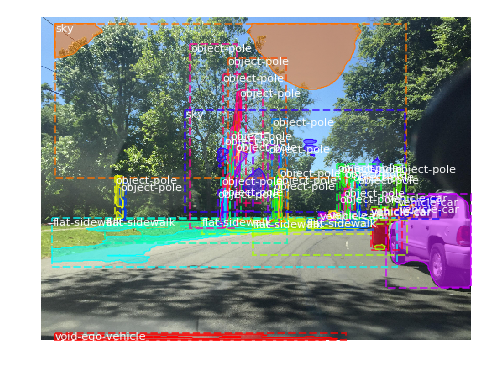

In [9]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

test_img = testData.load_image(450)
results  = model.detect([test_img], verbose=1)
r = results[0]

if 'src.visualize' in sys.modules : del sys.modules['src.visualize']
import src.visualize as visualize
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            testData.class_names, r['scores'], ax=get_ax())

# SCRATCHPAD